# Data Science - Module 1 - Final Project Submission

* Student Name: **James Toop**
* Student Pace: **Self Paced**
* Scheduled project review date/time: **10th September 2020 - 3pm GMT**
* Instructor name: **Jeff Herman**
* Blog post URL: **TBC**

## Exploratory Data Analysis (EDA)

This notebook presents a more detailed investigation of the data, exploring a number of themes to aide business decision making, specifically:

1. [What is the size of the opportunity to the business? i.e. why should we venture into the film industry in the first place?](#q1) 
2. [What is the potential return (and risk) on the investment? i.e. showing the profitability of film.](#q2)
3. Is there a relationship between production budget and box office takings?
4. Is there a relationship between ratings and box office takings? i.e. Does a film with lower ratings also fail at the box office?
5. What types of films "perform" better than others? Performance will have to be measured by ratings and Gross INcome (box office takings) as we don't have the data to measure performance on Net Income.


* Which studios have been producing the most films?
* Number of films by genre
* Number of films by year and by genre


In [1]:
# Import the relevant libraries
import pandas as pd
import numpy as np
import seaborn as sns
import sqlite3
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

<a name="q1"></a>
### 1. What is the size of the opportunity to the business? 

Why should we go into the film industry / produce original video content in the first place?

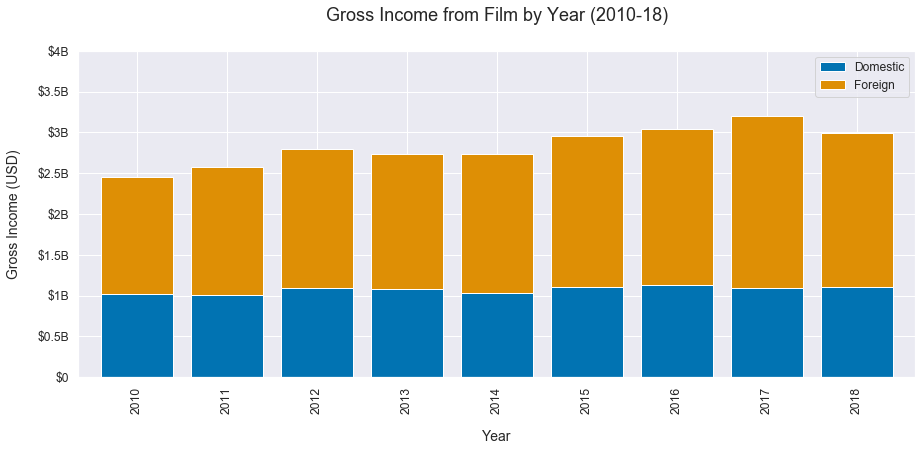

In [112]:
# Import the Box Office Mojo data

df_bom = pd.read_csv('zippedData/bom.movie_gross.csv.gz', compression='gzip', header=0, thousands=",")


# Handle missing values and datatypes to aide analysis

df_bom[['domestic_gross', 'foreign_gross']] = df_bom[['domestic_gross', 'foreign_gross']].fillna(0).astype(int)
df_bom[['year']] = df_bom[['year']].astype(str)


# Handle the incorrect foreign gross income data, out by a factor of 1,000,000 for the following films:
#  - The Fate of the Furious
#  - Jurassic World
#  - Star Wars: The Force Awakens
#  - Furious 7
#  - Avengers: Infinity War

df_bom.loc[df_bom.title.isin(['The Fate of the Furious',
                              'Jurassic World',
                              'Star Wars: The Force Awakens',
                              'Furious 7',
                              'Avengers: Infinity War'
                             ]) & (df_bom.foreign_gross < 1e6), 'foreign_gross'] = df_bom['foreign_gross'] * 1e6


# Handle any potential duplicates within the dataset based on film title and studio and sort by year

df_bom = df_bom.sort_values('year').drop_duplicates(subset=['title', 'studio'])


# Creating our first plot looking at Gross Income from Film year-on-year
sns.set(font_scale=1.1)
sns.set_palette(sns.color_palette('colorblind'))

existing_yvalues = [0,0.5e10,1e10,1.5e10,2e10,2.5e10,3e10,3.5e10,4e10]
readable_yvalues = ['$0','$0.5B','$1B','$1.5B','$2B','$2.5B','$3B','$3.5B','$4B']
chart_data = df_bom[['year','domestic_gross','foreign_gross']].set_index('year').groupby('year').sum()
chart_data.plot(kind='bar', stacked=True, figsize=(15,6), width=0.8)
plt.ylim(0,4e10)
plt.yticks(existing_yvalues, readable_yvalues)
plt.title('Gross Income from Film by Year (2010-18)', fontsize=18, pad=30)
plt.xlabel('Year', fontsize=14, labelpad=16)
plt.ylabel('Gross Income (USD)', fontsize=14, labelpad=16)
plt.legend(['Domestic','Foreign'])

plt.show()

<a name="q2"></a>
### 2. What is the potential return (and risk) on the investment? i.e. Showing the profitability of Film.

Return on investment, expressed as (net profit / production budget) * 100, made on films year-on-year.

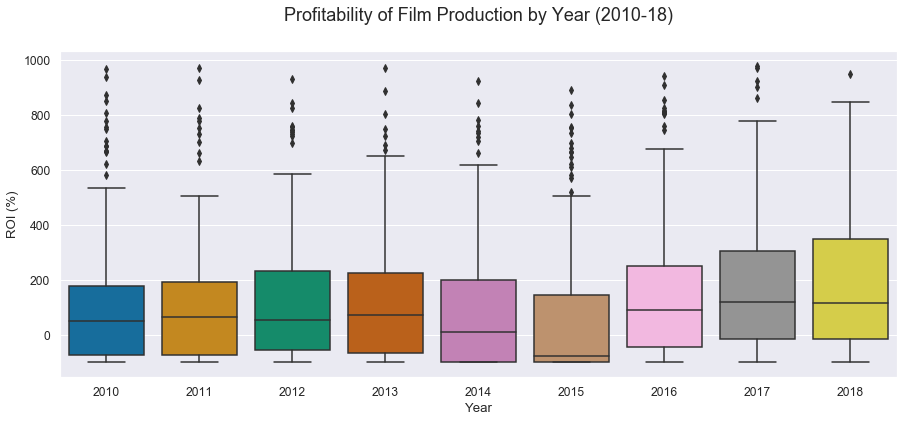

In [119]:
# Import TheNumbers - Movie Budgets dataset

df_tn_budgets = pd.read_csv('zippedData/tn.movie_budgets.csv.gz', compression='gzip', header=0)


# Remove text and convert datatypes to aide analysis

df_tn_budgets['production_budget'] = df_tn_budgets['production_budget'].str.replace('$', '')
df_tn_budgets['production_budget'] = df_tn_budgets['production_budget'].str.replace(',', '')
df_tn_budgets['production_budget'] = df_tn_budgets['production_budget'].astype(int)
df_tn_budgets['domestic_gross'] = df_tn_budgets['domestic_gross'].str.replace('$', '')
df_tn_budgets['domestic_gross'] = df_tn_budgets['domestic_gross'].str.replace(',', '')
df_tn_budgets['domestic_gross'] = df_tn_budgets['domestic_gross'].astype(int)
df_tn_budgets['worldwide_gross'] = df_tn_budgets['worldwide_gross'].str.replace('$', '')
df_tn_budgets['worldwide_gross'] = df_tn_budgets['worldwide_gross'].str.replace(',', '')
df_tn_budgets['worldwide_gross'] = df_tn_budgets['worldwide_gross'].astype(int)


# Add additional columns to the DataFrame for Release Year and Profit Margin

df_tn_budgets.insert(2, 'release_year', df_tn_budgets['release_date'].str[-4:].astype(int))
df_tn_budgets.insert(7, 'profit', (df_tn_budgets['worldwide_gross'] - df_tn_budgets['production_budget']))
df_tn_budgets.insert(8, 'roi', ((df_tn_budgets['profit'] / df_tn_budgets['production_budget'])*100).astype(float))


# Filter the dataframes to only show data between 2010 and 2018, remove outliers and sort by release year

df_tn_budgets = df_tn_budgets[(df_tn_budgets['release_year'] >=2010) & (df_tn_budgets['release_year'] <=2018)]
df_tn_budgets = df_tn_budgets[(df_tn_budgets['roi'] <= 1000) & (df_tn_budgets['roi'] >= -100)].sort_values('release_year')


# Creating a boxplot to show profitability of the film industry since 2010

plt.figure(figsize=(15,6))
plt.title('Profitability of Film Production by Year (2010-18)', fontsize=18, pad=30)
sns.boxplot(
    y=df_tn_budgets['roi'], 
    x=df_tn_budgets['release_year'], 
    data=df_tn_budgets, 
    width=0.8, 
    palette='colorblind').set(
    xlabel='Year', 
    ylabel='ROI (%)'
)

plt.show()
